In [64]:
import pandas as pd
import folium
import ast
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

# Load the data

In [116]:
df_pop = pd.read_excel('./data/ACS5yrNTA/demo_2016acs5yr_nta.xlsx')
print(df_pop.shape)

df_econ = pd.read_excel('./data/ACS5yrNTA/econ_2016acs5yr_nta.xlsx')
print(df_econ.shape)

df_house = pd.read_excel('./data/ACS5yrNTA/hous_2016acs5yr_nta.xlsx')
print(df_house.shape)

df_soc = pd.read_excel('./data/ACS5yrNTA/soc_2016acs5yr_nta.xlsx')
print(df_soc.shape)

(195, 484)


In [26]:
df_bus = pd.read_csv('./data/Legally_Operating_Businesses_20240905.csv')
print(df_bus.shape)

/var/folders/mg/sts1jc3x4vg3ykt3408_lxs00000gn/T/ipykernel_7670/1500472773.py:1: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bus = pd.read_csv('./data/Legally_Operating_Businesses_20240905.csv')


(281413, 27)


In [28]:
# check if there is any trader joe
df_bus[df_bus['Business Name'].str.lower().str.contains('trader') & df_bus['Business Name'].str.lower().str.contains('joe')]

,DCA License Number,License Type,License Expiration Date,License Status,License Creation Date,Industry,Business Name,Business Name 2,Address Building,Address Street Name,...,Community Board,Council District,BIN,BBL,NTA,Census Tract,Detail,Longitude,Latitude,Location


In [30]:
# we want to focus on NYC only
print(df_bus['Address Borough'].value_counts())

# filter the dataset to only keep 5 boroughs, remove rows with mispelled
NYC_BOROUGHS = ['Queens', 'Brooklyn', 'Manhattan', 'Bronx', 'Staten Island']
df_bus = df_bus[df_bus['Address Borough'].isin(NYC_BOROUGHS)]
print(df_bus.shape)

Address Borough
Brooklyn         50346
Queens           45800
Manhattan        40435
Bronx            24695
Outside NYC      14775
Staten Island     9265
MANHATTAN           46
QUEENS              17
BROOKLYN            15
BRONX                9
Name: count, dtype: int64
(170541, 27)


In [36]:
# we want to focus on recommending the specific NTA (Neighborhood Tabulation Area) where the business is located.
# remove row with missing NTA
df_bus = df_bus.dropna(subset=['NTA'])
print(df_bus.shape)

df_bus[['Address Borough', 'NTA']].value_counts()

(137476, 27)


Address Borough  NTA 
Manhattan        MN17    4222
                 MN13    2288
                 MN24    1936
Queens           QN70    1905
                 QN61    1904
                         ... 
Brooklyn         MN24       1
Manhattan        BK78       1
                 BK91       1
Brooklyn         MN19       1
Queens           MN36       1
Name: count, Length: 209, dtype: int64

In [32]:
# check how many industries
df_bus['Industry'].value_counts()

Industry
Tobacco Retail Dealer             39606
Home Improvement Contractor       32959
Secondhand Dealer - General       17108
Electronics Store                 15250
Stoop Line Stand                   9880
Electronic & Appliance Service     7183
Laundry                            6891
Laundries                          4909
Laundry Jobber                     4379
Sidewalk Cafe                      3841
Garage                             3682
Electronic Cigarette Dealer        3536
Secondhand Dealer - Auto           2942
Dealer In Products                 2717
Parking Lot                        1848
Tow Truck Company                  1593
Employment Agency                  1457
Pawnbroker                         1123
Amusement Device Temporary         1101
Special Sale                       1052
Amusement Device Portable           997
Pedicab Business                    815
Newsstand                           682
Debt Collection Agency              650
Cabaret                        

In [48]:
# assume that the trader joe's lies in between  Stoop Line Stand  and General Vendor industries
# note that general vendor was filtered as they are outside the NYC
# let's use the sum of businesses of two industries as indicator of supermarket success

df_sup_success = df_bus[df_bus['Industry'].isin(['Stoop Line Stand', 'General Vendor'])]
df_sup_success = df_sup_success[['Address Borough', 'NTA', 'Business Name', 'Industry']]
df_sup_success = df_sup_success.groupby(['Address Borough', 'NTA', 'Industry'])['Business Name'].count().reset_index()
df_sup_success = df_sup_success.rename(columns={'Business Name':'shop_count', 'NTA':'GeoID'})
df_sup_success.head(5)

,Address Borough,GeoID,Industry,shop_count
0,Bronx,BX01,Stoop Line Stand,13
1,Bronx,BX03,Stoop Line Stand,6
2,Bronx,BX05,Stoop Line Stand,54
3,Bronx,BX06,Stoop Line Stand,30
4,Bronx,BX07,Stoop Line Stand,10


# Feature Engineering

There are too many variables so it would be best to filter them out and using the shop_count as indicator

In [107]:
# using correlation features
# merge df_pop

df_pop_fea = pd.merge(df_pop, df_sup_success, on='GeoID')
df_pop_fea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Columns: 487 entries, GeoType to shop_count
dtypes: float64(385), int64(96), object(6)
memory usage: 688.8+ KB


In [109]:
# remove object columns
df_pop_fea = df_pop_fea.drop(columns=['GeoType','GeogName', 'GeoID', 'Borough', 'Address Borough', 'Industry'])
df_pop_fea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Columns: 481 entries, Pop_1E to shop_count
dtypes: float64(385), int64(96)
memory usage: 680.3 KB


In [111]:
# remove columns that contain all missing rows
df_pop_fea = df_pop_fea.drop(columns=df_pop_fea.columns[df_pop_fea.isnull().all()].to_list())

In [112]:
# replace missing value with mean
for col in df_pop_fea.columns:
    col_mean = df_pop_fea[col].mean()
    df_pop_fea[col].fillna(col_mean, inplace=True)

print(df_pop_fea.columns[df_pop_fea.isnull().any()])

Index([], dtype='object')


/var/folders/mg/sts1jc3x4vg3ykt3408_lxs00000gn/T/ipykernel_7670/1246015328.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pop_fea[col].fillna(col_mean, inplace=True)


In [113]:
df_pop_fea

,Pop_1E,Pop_1M,Pop_1C,Pop_1P,MaleE,MaleM,MaleC,MaleP,MaleZ,FemE,...,AsnOAsnM,AsnOAsnC,AsnOAsnP,AsnOAsnZ,Asn2plE,Asn2plM,Asn2plC,Asn2plP,Asn2plZ,shop_count
0,33163,1246.0,2.3,100.0,16686,781.0,2.8,50.3,1.4,16477,...,42.000000,54.900000,0.400000,0.300000,152,103.000000,41.400000,1.300000,0.800000,34
1,79134,1724.0,1.3,100.0,37829,1075.0,1.7,47.8,0.9,41305,...,113.000000,60.900000,1.000000,1.000000,93,61.000000,40.200000,0.800000,0.500000,152
2,75318,1993.0,1.6,100.0,36491,1276.0,2.1,48.4,1.1,38827,...,29.000000,67.800000,1.100000,1.200000,56,52.000000,56.700000,2.400000,2.200000,25
3,64267,1675.0,1.6,100.0,31283,1083.0,2.1,48.7,1.1,32984,...,57.000000,73.200000,0.200000,0.200000,232,175.000000,45.900000,0.900000,0.700000,105
4,91646,1975.0,1.3,100.0,44651,1241.0,1.7,48.7,0.9,46995,...,190.000000,41.500000,0.700000,0.500000,428,202.000000,28.700000,1.100000,0.500000,173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,37395,1423.0,2.3,100.0,17966,926.0,3.1,48.0,1.7,19429,...,54.000000,84.700000,5.600000,7.500000,0,89.626866,59.963433,1.870896,1.837313,32
177,35752,1461.0,2.5,100.0,17105,998.0,3.5,47.8,2.0,18647,...,73.623077,77.086154,1.812308,2.182308,0,89.626866,59.963433,1.870896,1.837313,40
178,28437,1232.0,2.6,100.0,13282,749.0,3.4,46.7,1.7,15155,...,50.000000,78.100000,1.100000,1.400000,67,97.000000,88.400000,1.900000,2.700000,30
179,65043,1793.0,1.7,100.0,30020,1109.0,2.2,46.2,1.1,35023,...,13.000000,74.100000,1.400000,1.600000,0,89.626866,59.963433,1.870896,1.837313,42


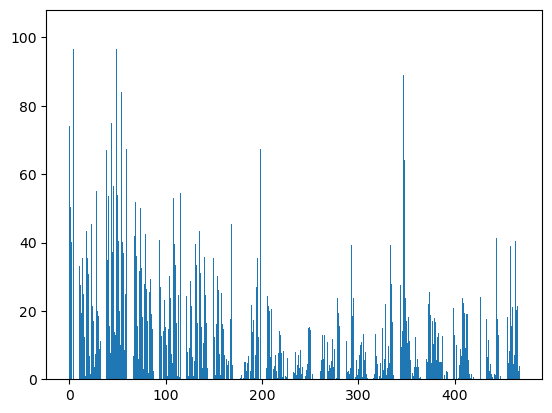

In [114]:
# https://machinelearningmastery.com/feature-selection-for-regression-data/
#  Feature selection instead, takes the target into consideration. 
# It will rank your input variables in terms of how useful they are to predict the target value.
# it is different from PCA that try to reduce dimensionality by exploring how one feature of the data is expressed 
# in terms of the other features(linear dependency)

def select_features(X_train, y_train):
 # configure to select all features
 fs = SelectKBest(score_func=f_regression, k=10)
 # learn relationship from training data
 fs.fit(X_train, y_train)
 # transform train input data
 X_train_fs = fs.transform(X_train)
 return X_train_fs, fs

# feature selection
X_train_fs, fs = select_features(df_pop_fea.drop(columns=['shop_count']), df_pop_fea['shop_count'])
# # what are scores for the features
# for i in range(len(fs.scores_)):
#  print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [115]:
df_pop = pd.merge(df_pop, df_sup_success, on='GeoID')
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Columns: 487 entries, GeoType to shop_count
dtypes: float64(385), int64(96), object(6)
memory usage: 688.8+ KB


In [97]:
df_pop

,GeoType,GeogName,GeoID,Borough,Pop_1E,Pop_1M,Pop_1C,Pop_1P,Pop_1Z,MaleE,...,Asn2plM,Asn2plC,Asn2plP,Asn2plZ,Address Borough_x,Industry_x,shop_count_x,Address Borough_y,Industry_y,shop_count_y
0,NTA2010,Bath Beach,BK27,Brooklyn,33163,1246.0,2.3,100.0,NaN,16686,...,103.0,41.4,1.3,0.8,Brooklyn,Stoop Line Stand,34,Brooklyn,Stoop Line Stand,34
1,NTA2010,Bay Ridge,BK31,Brooklyn,79134,1724.0,1.3,100.0,NaN,37829,...,61.0,40.2,0.8,0.5,Brooklyn,Stoop Line Stand,152,Brooklyn,Stoop Line Stand,152
2,NTA2010,Bedford,BK75,Brooklyn,75318,1993.0,1.6,100.0,NaN,36491,...,52.0,56.7,2.4,2.2,Brooklyn,Stoop Line Stand,25,Brooklyn,Stoop Line Stand,25
3,NTA2010,Bensonhurst East,BK29,Brooklyn,64267,1675.0,1.6,100.0,NaN,31283,...,175.0,45.9,0.9,0.7,Brooklyn,Stoop Line Stand,105,Brooklyn,Stoop Line Stand,105
4,NTA2010,Bensonhurst West,BK28,Brooklyn,91646,1975.0,1.3,100.0,NaN,44651,...,202.0,28.7,1.1,0.5,Brooklyn,Stoop Line Stand,173,Brooklyn,Stoop Line Stand,173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,NTA2010,West Concourse,BX63,The Bronx,37395,1423.0,2.3,100.0,NaN,17966,...,NaN,NaN,NaN,NaN,Bronx,Stoop Line Stand,32,Bronx,Stoop Line Stand,32
183,NTA2010,West Farms-Bronx River,BX08,The Bronx,35752,1461.0,2.5,100.0,NaN,17105,...,NaN,NaN,NaN,NaN,Bronx,Stoop Line Stand,40,Bronx,Stoop Line Stand,40
184,NTA2010,Westchester-Unionport,BX59,The Bronx,28437,1232.0,2.6,100.0,NaN,13282,...,97.0,88.4,1.9,2.7,Bronx,Stoop Line Stand,30,Bronx,Stoop Line Stand,30
185,NTA2010,Williamsbridge-Olinville,BX44,The Bronx,65043,1793.0,1.7,100.0,NaN,30020,...,NaN,NaN,NaN,NaN,Bronx,Stoop Line Stand,42,Bronx,Stoop Line Stand,42


In [199]:
# can we do the same for all NTA-level data
df_nta = df_pop.copy()
df_nta = pd.merge(df_nta, df_econ, on='GeoID')
df_nta = df_nta.drop(columns=['GeoType_x', 'GeoType_y', 'GeogName_x', 'GeogName_y', 'Borough_x', 'Borough_y'])
df_nta = pd.merge(df_nta, df_house, on='GeoID')
df_nta = pd.merge(df_nta, df_soc, on='GeoID')
df_nta = df_nta.drop(columns=['GeoType_x', 'GeoType_y', 'GeogName_x', 'GeogName_y', 'Borough_x', 'Borough_y'])
df_nta.shape

(195, 4366)

In [200]:
df_nta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Columns: 4366 entries, GeoID to UnclsNRZ
dtypes: float64(3511), int64(854), object(1)
memory usage: 6.5+ MB


In [201]:
df_nta = pd.merge(df_nta, df_sup_success, on='GeoID')

In [203]:
# remove columns that contain all missing rows
df_nta = df_nta.drop(columns=df_nta.columns[df_nta.isnull().all()].to_list())

# replace missing value with mean
for col in df_nta.columns:
    if col not in ['GeoID', 'Address Borough', 'Industry']:
        col_mean = df_nta[col].mean()
        df_nta[col].fillna(col_mean, inplace=True)

print(df_nta.columns[df_nta.isnull().any()])

/var/folders/mg/sts1jc3x4vg3ykt3408_lxs00000gn/T/ipykernel_7670/687371754.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_nta[col].fillna(col_mean, inplace=True)


Index([], dtype='object')


/Users/TinyJiew/opt/anaconda3/envs/pantalone/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:379: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)


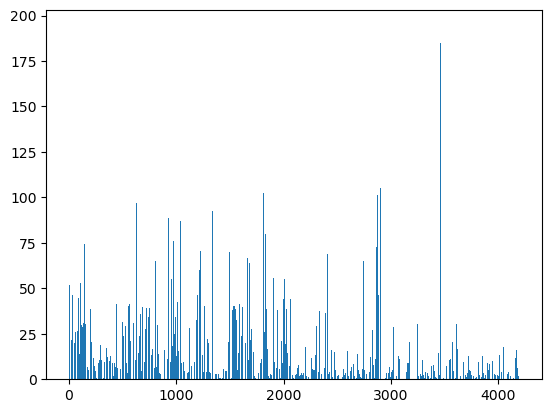

In [204]:
# feature selection
X_train_fs, fs = select_features(df_nta.drop(columns=['shop_count', 'GeoID', 'Address Borough', 'Industry']), df_nta['shop_count'])
# # what are scores for the features
# for i in range(len(fs.scores_)):
#  print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

# Clustering

In [205]:

X_train_fs

array([[  938.,  1047., 16333., ..., 13032., 21372., 13032.],
       [ 1486.,  3714., 27789., ..., 15915., 37733., 15915.],
       [ 1234.,  3965., 14463., ..., 10511., 27889., 10511.],
       ...,
       [  362.,  1731.,  9631., ...,  6726., 17202.,  6726.],
       [  709.,  1918., 25625., ...,  6485., 18319.,  6485.],
       [  670.,  1593., 18191., ...,  3247., 10131.,  3247.]])

Text(0.5, 1.0, 'Elbow Method For Optimal k')

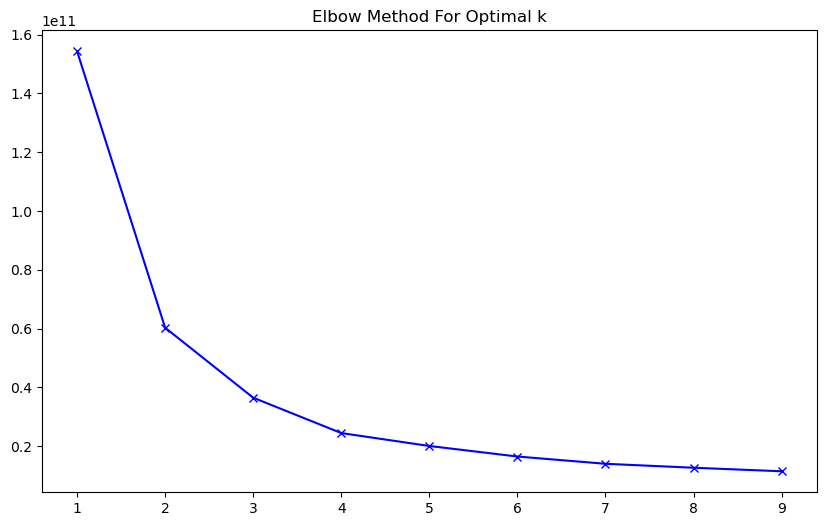

In [206]:
# perform clustering based on the feature selections
sum_of_squared_distances = []

# maximum of 10 clusters
K = range(1,10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=20).fit(X_train_fs)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.title('Elbow Method For Optimal k')

In [207]:
# k = 4 is optimal number
# let's breakdown the NTA into 3 groups

# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=100).fit(X_train_fs)

In [250]:
nyc_label = df_nta.copy()
nyc_label['label'] = kmeans.labels_
nyc_label

,GeoID,Pop_1E,Pop_1M,Pop_1C,Pop_1P,MaleE,MaleM,MaleC,MaleP,MaleZ,...,OthrZ,UnclsNRE,UnclsNRM,UnclsNRC,UnclsNRP,UnclsNRZ,Address Borough,Industry,shop_count,label
0,BK27,33163,1246.0,2.3,100.0,16686,781.0,2.8,50.3,1.4,...,3.1,6697,1100.0,10.0,20.2,3.2,Brooklyn,Stoop Line Stand,34,2
1,BK31,79134,1724.0,1.3,100.0,37829,1075.0,1.7,47.8,0.9,...,1.8,7423,806.0,6.6,9.4,1.0,Brooklyn,Stoop Line Stand,152,1
2,BK75,75318,1993.0,1.6,100.0,36491,1276.0,2.1,48.4,1.1,...,2.0,9693,1035.0,6.5,12.9,1.3,Brooklyn,Stoop Line Stand,25,2
3,BK29,64267,1675.0,1.6,100.0,31283,1083.0,2.1,48.7,1.1,...,2.3,9077,1007.0,6.7,14.1,1.5,Brooklyn,Stoop Line Stand,105,1
4,BK28,91646,1975.0,1.3,100.0,44651,1241.0,1.7,48.7,0.9,...,1.8,15409,1377.0,5.4,16.8,1.5,Brooklyn,Stoop Line Stand,173,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,BX63,37395,1423.0,2.3,100.0,17966,926.0,3.1,48.0,1.7,...,2.6,3362,664.0,12.0,9.0,1.7,Bronx,Stoop Line Stand,32,2
177,BX08,35752,1461.0,2.5,100.0,17105,998.0,3.5,47.8,2.0,...,2.8,2735,530.0,11.8,7.6,1.4,Bronx,Stoop Line Stand,40,2
178,BX59,28437,1232.0,2.6,100.0,13282,749.0,3.4,46.7,1.7,...,3.2,2643,504.0,11.6,9.3,1.7,Bronx,Stoop Line Stand,30,0
179,BX44,65043,1793.0,1.7,100.0,30020,1109.0,2.2,46.2,1.1,...,2.1,6252,803.0,7.8,9.6,1.2,Bronx,Stoop Line Stand,42,2


# Analyse clustering result

In [251]:
nyc_label['Pop_Total_25_44'] = nyc_label.apply(lambda x: x['Pop25t29E'] + x['Pop30t34E'] + x['Pop35t39E'] + x['Pop40t44E'], axis=1)
nyc_label['Pop_Pct_25_44'] = nyc_label.apply(lambda x: x['Pop_Total_25_44'] / x['Pop_1E'] , axis=1)

In [252]:
nyc_label['Pop_Pct_Hisp_Latin'] = nyc_label.apply(lambda x: x['Hsp1E'] / x['Pop_2E'], axis=1)
nyc_label['Pop_Pct_Non_Hisp_Latin'] = nyc_label.apply(lambda x: x['NHspE'] / x['Pop_2E'], axis=1)

In [253]:
nyc_label['Pop_Pct_Employ'] = nyc_label.apply(lambda x: x['CvEm16pl1E'] / x['Pop16plE'], axis=1) 

#earning $75,000 to $99,999
nyc_label['Pop_Pct_Earn_75_99'] = nyc_label.apply(lambda x: x['HHI75t99E'] / x['HH2E'], axis=1)
nyc_label['Mean_Household_Income'] = nyc_label['MnHHIncE']

#healthy with insurance coverage of overall employment
nyc_label['Pop_Pct_Healthy'] = nyc_label.apply(lambda x: x['EmHInsE'] / x['CvLFEmE'], axis=1) 

In [254]:
# with car
nyc_label['Pop_Pct_With_Car'] = nyc_label.apply(lambda x: (x['Vhcl1AvE'] + x['Vhcl2AvE'] + x['Vhcl3plAvE']) / x['OcHU4E'], axis=1)
nyc_label['House_Median'] = nyc_label['MdVlE'] #house price
nyc_label['Rent_Median'] = nyc_label['MdGRE']

In [255]:
# have family
nyc_label['Pop_Pct_with_Family'] = nyc_label.apply(lambda x: x['Fam1E'] / x['HH1E'], axis=1) 

#education #Bachelor's degree or higher
nyc_label['Pop_Pct_With_Degree'] = nyc_label.apply(lambda x: x['EA_BchDHE'] / x['EA_P25plE'], axis=1) 

In [256]:
# let focus on certain varaibles
# from the demographics - https://www.businessinsider.com/typical-trader-joes-shopper-demographic-younger-married-earning-80k-income-2021-9
# let's filter younger, married with the age between 25-44 years old, and earn more than 80,000 a year

analyse_columns = ['Pop_Total_25_44', 'Pop_Pct_25_44', 'Pop_Pct_Hisp_Latin', 'Pop_Pct_Non_Hisp_Latin', 'Pop_Pct_Employ', 'Pop_Pct_Earn_75_99', 
                   'Mean_Household_Income', 'Pop_Pct_Healthy', 'Pop_Pct_With_Car', 'House_Median', 'Rent_Median', 
                   'Pop_Pct_with_Family', 'Pop_Pct_With_Degree', 'shop_count', 'label', 'GeoID']

nyc_label = nyc_label[analyse_columns]

In [257]:
nyc_label

,Pop_Total_25_44,Pop_Pct_25_44,Pop_Pct_Hisp_Latin,Pop_Pct_Non_Hisp_Latin,Pop_Pct_Employ,Pop_Pct_Earn_75_99,Mean_Household_Income,Pop_Pct_Healthy,Pop_Pct_With_Car,House_Median,Rent_Median,Pop_Pct_with_Family,Pop_Pct_With_Degree,shop_count,label,GeoID
0,10522,0.317281,0.176733,0.823267,0.553230,0.118306,75950.0,0.851433,0.609205,685011.0,1299.0,0.718148,0.336202,34,2,BK27
1,24615,0.311055,0.178608,0.821392,0.594175,0.122674,86319.0,0.889538,0.548691,687001.0,1385.0,0.565443,0.464265,152,1,BK31
2,25584,0.339680,0.194933,0.805067,0.589010,0.087072,62616.0,0.871836,0.312752,722811.0,1165.0,0.557965,0.321807,25,2,BK75
3,18681,0.290678,0.123283,0.876717,0.553531,0.115293,65715.0,0.829711,0.540046,657026.0,1209.0,0.733583,0.301847,105,1,BK29
4,28128,0.306920,0.145975,0.854025,0.561085,0.114614,70198.0,0.825890,0.526765,708946.0,1259.0,0.729948,0.262382,173,3,BK28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,11003,0.294237,0.707046,0.292954,0.533988,0.064834,37550.0,0.742167,0.228866,213234.0,1098.0,0.650325,0.139636,32,2,BX63
177,10220,0.285858,0.646090,0.353910,0.507790,0.078550,39917.0,0.730384,0.394016,453009.0,1108.0,0.683944,0.092649,40,2,BX08
178,7933,0.278968,0.636249,0.363751,0.522259,0.129174,57590.0,0.832139,0.522319,425647.0,1308.0,0.696242,0.185358,30,0,BX59
179,17193,0.264333,0.252156,0.747844,0.533886,0.090118,53405.0,0.857238,0.512452,378872.0,1204.0,0.680864,0.187137,42,2,BX44


In [258]:
# merge back 
nyc_label = pd.merge(nyc_label, df_pop[['GeogName', 'GeoID', 'Borough']], on = 'GeoID')
nyc_label

,Pop_Total_25_44,Pop_Pct_25_44,Pop_Pct_Hisp_Latin,Pop_Pct_Non_Hisp_Latin,Pop_Pct_Employ,Pop_Pct_Earn_75_99,Mean_Household_Income,Pop_Pct_Healthy,Pop_Pct_With_Car,House_Median,Rent_Median,Pop_Pct_with_Family,Pop_Pct_With_Degree,shop_count,label,GeoID,GeogName,Borough
0,10522,0.317281,0.176733,0.823267,0.553230,0.118306,75950.0,0.851433,0.609205,685011.0,1299.0,0.718148,0.336202,34,2,BK27,Bath Beach,Brooklyn
1,24615,0.311055,0.178608,0.821392,0.594175,0.122674,86319.0,0.889538,0.548691,687001.0,1385.0,0.565443,0.464265,152,1,BK31,Bay Ridge,Brooklyn
2,25584,0.339680,0.194933,0.805067,0.589010,0.087072,62616.0,0.871836,0.312752,722811.0,1165.0,0.557965,0.321807,25,2,BK75,Bedford,Brooklyn
3,18681,0.290678,0.123283,0.876717,0.553531,0.115293,65715.0,0.829711,0.540046,657026.0,1209.0,0.733583,0.301847,105,1,BK29,Bensonhurst East,Brooklyn
4,28128,0.306920,0.145975,0.854025,0.561085,0.114614,70198.0,0.825890,0.526765,708946.0,1259.0,0.729948,0.262382,173,3,BK28,Bensonhurst West,Brooklyn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,11003,0.294237,0.707046,0.292954,0.533988,0.064834,37550.0,0.742167,0.228866,213234.0,1098.0,0.650325,0.139636,32,2,BX63,West Concourse,The Bronx
177,10220,0.285858,0.646090,0.353910,0.507790,0.078550,39917.0,0.730384,0.394016,453009.0,1108.0,0.683944,0.092649,40,2,BX08,West Farms-Bronx River,The Bronx
178,7933,0.278968,0.636249,0.363751,0.522259,0.129174,57590.0,0.832139,0.522319,425647.0,1308.0,0.696242,0.185358,30,0,BX59,Westchester-Unionport,The Bronx
179,17193,0.264333,0.252156,0.747844,0.533886,0.090118,53405.0,0.857238,0.512452,378872.0,1204.0,0.680864,0.187137,42,2,BX44,Williamsbridge-Olinville,The Bronx


In [259]:
# create new dataframe to summarise each label
results = []
for label in sorted(nyc_label.label.unique()):
    df = nyc_label[nyc_label.label == label]
    nta_names = df.GeogName.unique()
    nta_ids = df.GeoID.unique()
    label_dict = {
        'label': label,
        'NTA_Name': df.GeogName.unique(),
        'NTA_ID': df.GeoID.unique(),
        'Avg_Pop_Pct_25_44': df.Pop_Pct_25_44.mean(),
        'Avg_Pop_Pct_Hisp_Latin': df.Pop_Pct_Hisp_Latin.mean(), 
        'Avg_Pop_Pct_Non_Hisp_Latin': df.Pop_Pct_Non_Hisp_Latin.mean(), 
        'Avg_Pop_Pct_Employ': df.Pop_Pct_Employ.mean(), 
        'Avg_Pop_Pct_Earn_75_99': df.Pop_Pct_Earn_75_99.mean(), 
        'Avg_Pop_Pct_Healthy': df.Pop_Pct_Healthy.mean(),
        'Avg_Pop_Pct_With_Car': df.Pop_Pct_With_Car.mean(), 
        'Avg_House_Median': df.House_Median.mean(), 
        'Avg_Rent_Median': df.Rent_Median.mean(), 
        'Avg_Pop_Pct_with_Family': df.Pop_Pct_with_Family.mean(), 
        'Avg_Pop_Pct_With_Degree': df.Pop_Pct_With_Degree.mean(), 
        'Avg_shop_count': df.shop_count.mean()
    }
    results.append(label_dict)
    print(f"Group {label}")

Group 0
Group 1
Group 2
Group 3


In [260]:
df_results = pd.DataFrame(results)
df_results.head()

,label,NTA_Name,NTA_ID,Avg_Pop_Pct_25_44,Avg_Pop_Pct_Hisp_Latin,Avg_Pop_Pct_Non_Hisp_Latin,Avg_Pop_Pct_Employ,Avg_Pop_Pct_Earn_75_99,Avg_Pop_Pct_Healthy,Avg_Pop_Pct_With_Car,Avg_House_Median,Avg_Rent_Median,Avg_Pop_Pct_with_Family,Avg_Pop_Pct_With_Degree,Avg_shop_count
0,0,"[Brooklyn Heights-Cobble Hill, Brownsville, Ca...","[BK09, BK81, BK33, BK69, BK63, BK38, BK85, BK9...",0.307836,0.229470,0.770530,0.583063,0.118175,0.887134,0.557105,571015.791209,1425.483516,0.615693,0.385343,20.329670
1,1,"[Bay Ridge, Bensonhurst East, Bushwick North, ...","[BK31, BK29, BK77, BK78, BK50, BK17, BK32, MN2...",0.324830,0.439664,0.560336,0.584181,0.112762,0.793869,0.414146,491012.166667,1295.533333,0.643654,0.289699,76.400000
2,2,"[Bath Beach, Bedford, Brighton Beach, Crown He...","[BK27, BK75, BK19, BK61, BK83, BK30, BK91, BK8...",0.308825,0.311434,0.688566,0.559868,0.102535,0.839539,0.446194,517838.230769,1274.153846,0.632084,0.316656,37.153846
3,3,"[Bensonhurst West, Borough Park, Flatbush, Sun...","[BK28, BK88, BK42, BK34, MN36, QN29, QN22, QN28]",0.316512,0.327686,0.672314,0.573326,0.102282,0.767372,0.411173,550041.500000,1290.375000,0.687030,0.245135,162.750000


In [261]:
# for each attribute give me the label that has the highest average
for col in df_results.columns[3:]:
    if col != 'Avg_shop_count':
        max_index = df_results[col].idxmax()
        label = df_results.loc[max_index]['label']
    else:
        min_index = df_results[col].idxmin()
        label = df_results.loc[min_index]['label']
    print(f"Variable: {col} Label: {label}")

Variable: Avg_Pop_Pct_25_44 Label: 1
Variable: Avg_Pop_Pct_Hisp_Latin Label: 1
Variable: Avg_Pop_Pct_Non_Hisp_Latin Label: 0
Variable: Avg_Pop_Pct_Employ Label: 1
Variable: Avg_Pop_Pct_Earn_75_99 Label: 0
Variable: Avg_Pop_Pct_Healthy Label: 0
Variable: Avg_Pop_Pct_With_Car Label: 0
Variable: Avg_House_Median Label: 0
Variable: Avg_Rent_Median Label: 0
Variable: Avg_Pop_Pct_with_Family Label: 3
Variable: Avg_Pop_Pct_With_Degree Label: 0
Variable: Avg_shop_count Label: 0


In [277]:
# From the above analysis, we can see that label 0 is the best
# let's look on label 0
nyc_label_0 = nyc_label[nyc_label.label == 0]
nyc_label_0 = nyc_label_0.reset_index()
nyc_label_0.head(5)

,index,Pop_Total_25_44,Pop_Pct_25_44,Pop_Pct_Hisp_Latin,Pop_Pct_Non_Hisp_Latin,Pop_Pct_Employ,Pop_Pct_Earn_75_99,Mean_Household_Income,Pop_Pct_Healthy,Pop_Pct_With_Car,House_Median,Rent_Median,Pop_Pct_with_Family,Pop_Pct_With_Degree,shop_count,label,GeoID,GeogName,Borough
0,7,10075,0.417357,0.080737,0.919263,0.657177,0.108052,178252.0,0.951727,0.302188,768459.0,2084.0,0.438845,0.780695,12,0,BK09,Brooklyn Heights-Cobble Hill,Brooklyn
1,8,17558,0.292030,0.203147,0.796853,0.438172,0.059113,37892.0,0.855792,0.265033,372773.0,738.0,0.628016,0.111713,13,0,BK81,Brownsville,Brooklyn
2,12,17055,0.401644,0.189271,0.810729,0.663824,0.097068,138368.0,0.932188,0.413230,1099629.0,1753.0,0.565237,0.625414,26,0,BK33,Carroll Gardens-Columbia Street-Red Hook,Brooklyn
3,13,15269,0.395007,0.110128,0.889872,0.657070,0.140660,96050.0,0.897105,0.397291,638640.0,1630.0,0.448060,0.567578,26,0,BK69,Clinton Hill,Brooklyn
4,15,12963,0.308922,0.081836,0.918164,0.574054,0.118763,60472.0,0.854489,0.356623,688937.0,1263.0,0.614187,0.315271,15,0,BK63,Crown Heights South,Brooklyn


In [278]:
nyc_label_0['People_Per_Shop'] = nyc_label_0.apply(lambda x: (x['Pop_Total_25_44'] // x['shop_count']) if x['shop_count'] > 0 else x['Pop_Total_25_44'], axis=1)

<Axes: title={'center': 'NYC residential neighbourhoods'}, xlabel='People per shop', ylabel='Mean Household Income'>

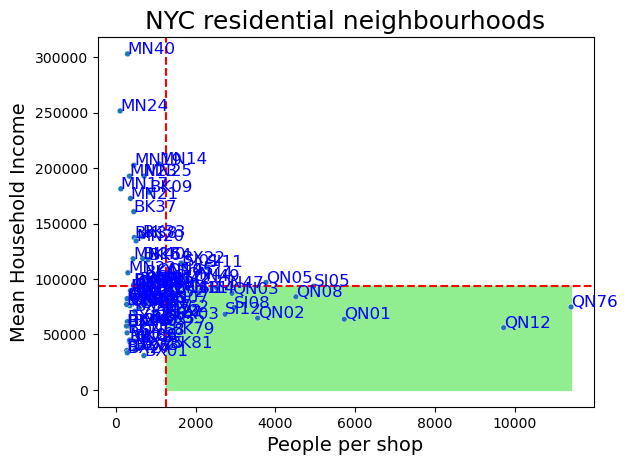

In [279]:
# visualisation
def scatter_text(x, y, text_column, data, title, xlabel, ylabel):
    # Create the scatter plot
    p1 = sns.scatterplot(x=x, y=y, data=data, size=8, legend=False)
    # Add text besides each point

    
    texts = [p1.text(data[x][line], data[y][line], 
             data[text_column][line], horizontalalignment='left', 
             size='large', color='blue') for line in range(0,data.shape[0])]
    # Set title and axis labels
    plt.title(title, size=18)
    plt.xlabel(xlabel, size=14)
    plt.ylabel(ylabel, size=14)
    return p1
    
# Add horizontal and vertical lines to mark the median values
avg_people_per_market = nyc_label_0['People_Per_Shop'].mean()
max_people_per_market = nyc_label_0['People_Per_Shop'].max()
avg_income = nyc_label_0['Mean_Household_Income'].mean()

plt.axhline(y=avg_income, color='r', linestyle='--')
plt.axvline(x=avg_people_per_market, color='r', linestyle='--')

# Highlight the optimal quadrant
plt.fill_between(x=np.arange(avg_people_per_market, max_people_per_market), y1=0, y2=avg_income, color='lightgreen')

# Draw and label the neighbourhood points
scatter_text('People_Per_Shop', 'Mean_Household_Income', 'GeoID',
             data = nyc_label_0, 
             title = 'NYC residential neighbourhoods', 
             xlabel = 'People per shop',
             ylabel = 'Mean Household Income')

In [299]:
nyc_label_0_filterd = nyc_label_0[(nyc_label_0['Mean_Household_Income'] > avg_income) & (nyc_label_0['People_Per_Shop'] > avg_people_per_market)]

In [300]:
nyc_label_0_filterd.loc[nyc_label_0_filterd.People_Per_Shop.idxmax()]

index                          123
Pop_Total_25_44               7529
Pop_Pct_25_44             0.274161
Pop_Pct_Hisp_Latin        0.084335
Pop_Pct_Non_Hisp_Latin    0.915665
Pop_Pct_Employ            0.645555
Pop_Pct_Earn_75_99        0.167739
Mean_Household_Income      96902.0
Pop_Pct_Healthy           0.928966
Pop_Pct_With_Car          0.859037
House_Median              422711.0
Rent_Median                 1604.0
Pop_Pct_with_Family       0.828849
Pop_Pct_With_Degree       0.268086
shop_count                       2
label                            0
GeoID                         QN05
GeogName                  Rosedale
Borough                     Queens
People_Per_Shop               3764
Name: 56, dtype: object

In [301]:
nyc_label_0_filterd.sort_values('People_Per_Shop')

,index,Pop_Total_25_44,Pop_Pct_25_44,Pop_Pct_Hisp_Latin,Pop_Pct_Non_Hisp_Latin,Pop_Pct_Employ,Pop_Pct_Earn_75_99,Mean_Household_Income,Pop_Pct_Healthy,Pop_Pct_With_Car,House_Median,Rent_Median,Pop_Pct_with_Family,Pop_Pct_With_Degree,shop_count,label,GeoID,GeogName,Borough,People_Per_Shop
39,88,6433,0.249942,0.119046,0.880954,0.590990,0.148183,103424.0,0.906985,0.896221,576588.0,1743.0,0.694031,0.484399,5,0,QN45,Douglas Manor-Douglaston-Little Neck,Queens,1286
82,164,6537,0.240818,0.218309,0.781691,0.543954,0.162954,114400.0,0.955554,0.728192,316903.0,1558.0,0.541464,0.585293,4,0,BX22,North Riverdale-Fieldston-Riverdale,The Bronx,1634
62,133,6810,0.237299,0.070562,0.929438,0.566431,0.131069,111603.0,0.977986,0.947752,561305.0,1139.0,0.807792,0.337119,4,0,SI01,Annadale-Huguenot-Prince's Bay-Eltingville,Staten Island,1702
43,98,5287,0.226482,0.092872,0.907128,0.541624,0.163012,99771.0,0.929732,0.893798,463320.0,1512.0,0.600443,0.410323,3,0,QN44,Glen Oaks-Floral Park-New Hyde Park,Queens,1762
61,130,7754,0.249405,0.142522,0.857478,0.564573,0.125563,98714.0,0.880378,0.890932,663953.0,1632.0,0.737786,0.360989,4,0,QN49,Whitestone,Queens,1938
63,134,6805,0.274462,0.096475,0.903525,0.570162,0.147961,110587.0,0.938116,0.910312,574514.0,1213.0,0.771098,0.326976,3,0,SI11,Charleston-Richmond Valley-Tottenville,Staten Island,2268
56,123,7529,0.274161,0.084335,0.915665,0.645555,0.167739,96902.0,0.928966,0.859037,422711.0,1604.0,0.828849,0.268086,2,0,QN05,Rosedale,Queens,3764
